In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

Using TensorFlow backend.


### Load the data into Pandas dataframe

In [3]:
df = pd.read_csv('../input/tweets/yo.csv',delimiter=',',encoding='latin-1')
df.head()

,date,text,created_at,favorite_count,changes,label
0,2020-07-13,So hard to watch @FoxNews anymore. They are wo...,2020-07-13 13:30:42,117169,0.019997,True
1,2020-07-13,Never in history have Police been treated so b...,2020-07-13 12:05:39,191214,0.019997,True
2,2020-07-13,âRepublican voter registration is way up Dem...,2020-07-13 11:54:38,127048,0.019997,True
3,2020-07-13,Is this what you want for your President??? Wi...,2020-07-13 11:41:35,85316,0.019997,True
4,2020-07-12,No Radical Left anarchists agitators looters o...,2020-07-12 12:30:36,194467,-0.290001,False


Drop the columns that are not required for the neural network.

In [4]:
df.drop(['date', 'created_at', 'favorite_count','changes'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17413 entries, 0 to 17412
Data columns (total 2 columns):
text     17413 non-null object
label    17413 non-null bool
dtypes: bool(1), object(1)
memory usage: 153.1+ KB


Understand the distribution better.

Text(0.5,1,'Tweets on good days for US Dollar')

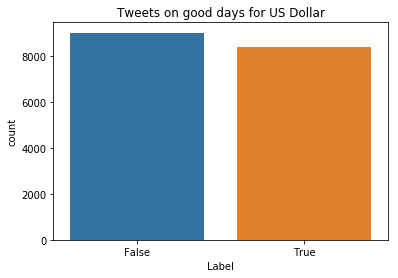

In [5]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Tweets on good days for US Dollar')

* Create input and output vectors.
* Process the labels.

In [6]:
X = df.text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

In [7]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

### Data Processing


In [8]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

### RNN


In [9]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [10]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

Fit on the training data.

In [11]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 11840 samples, validate on 2961 samples
Epoch 1/10
11840/11840 [==============================] - 24s 2ms/step - loss: 0.6928 - acc: 0.5142 - val_loss: 0.6926 - val_acc: 0.5198
Epoch 2/10
11840/11840 [==============================] - 24s 2ms/step - loss: 0.6888 - acc: 0.5378 - val_loss: 0.6917 - val_acc: 0.5248
Epoch 3/10
11840/11840 [==============================] - 24s 2ms/step - loss: 0.6734 - acc: 0.5798 - val_loss: 0.7107 - val_acc: 0.5319


So, it's only barely better than coin flip (0.5), but stock prices and such are incredibly hard to predict

In [12]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

Evaluate the model on the test set.

In [13]:
accr = model.evaluate(test_sequences_matrix,Y_test)

2612/2612 [==============================] - 2s 713us/step


more stats

In [14]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.713
  Accuracy: 0.532


In [27]:
sample_texts = ["worst trade deal",'coronavirus','medicare and social security','win','the coronavirus is a hoax','obama','radical left']

txts = tok.texts_to_sequences(sample_texts)
txts = sequence.pad_sequences(txts, maxlen=max_len)
preds = model.predict(txts)
print(preds)

[[ 0.25569779]
 [ 0.27971172]
 [ 0.34774569]
 [ 0.37353772]
 [ 0.25707743]
 [ 0.35605508]
 [ 0.30775592]]


In [28]:
sample_texts = ["oh there is a big huge wall to keep out all the illegal immigrants","china china china china"]

txts = tok.texts_to_sequences(sample_texts)
txts = sequence.pad_sequences(txts, maxlen=max_len)
preds = model.predict(txts)
preds

array([[ 0.52055335],
       [ 0.22492996]], dtype=float32)

ModuleNotFoundError: No module named 'tensorflow.keras'